## Análise dos Microdados do ENEM 2023

_A análise dos microdados do ENEM 2023 busca explorar padrões e tendências relacionados ao desempenho dos participantes. Foram elaborados gráficos que mostram a nota média por estado (excluindo a redação), além de uma regressão avaliando a relação entre os componentes da nota geral. Também analisamos a relação entre renda e desempenho, o desempenho na redação por tipo de escola e a presença na prova por raça. Esses dados fornecem insights sobre desigualdades educacionais e regionais, além de revelar como diferentes fatores sociais e econômicos impactam o desempenho dos estudantes._

## Importação

Primeiro importaremos as bibliotecas:

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import unicodedata
import statsmodels.api as sm
import squarify
import plotly.express as px
from folium import Choropleth

## Análise por Estado

#### Leitura do arquivo

In [41]:
caminho = r"dataset.csv"
dataset = pd.read_csv(caminho, sep=',', encoding='latin-1')

# Recarregar os dados do shapefile e do ENEM
shapefile_path = 'Dados-mapa/br.shp'
mapa_brasil = gpd.read_file(shapefile_path)

#### *Código para o mapa com as médias por estado*

In [ ]:
# Função para normalizar nomes
def normalizar_nome(nome):
    if pd.isna(nome):
        return nome
    return ''.join(c for c in unicodedata.normalize('NFD', nome) if unicodedata.category(c) != 'Mn')

# Normalizar os nomes no shapefile
mapa_brasil['name'] = mapa_brasil['name'].apply(normalizar_nome)

# Mapeamento de nomes para siglas
mapeamento_manual = {
    "Acre": "AC", "Alagoas": "AL", "Amazonas": "AM", "AmapA¡": "AP", "Bahia": "BA",
    "CearA¡": "CE", "Distrito Federal": "DF", "EspA­rito Santo": "ES", "GoiA¡s": "GO",
    "MaranhA£o": "MA", "Minas Gerais": "MG", "Mato Grosso do Sul": "MS", "Mato Grosso": "MT",
    "ParA¡": "PA", "ParaA­ba": "PB", "Pernambuco": "PE", "PiauA­": "PI", "ParanA¡": "PR",
    "Rio de Janeiro": "RJ", "Rio Grande do Norte": "RN", "RondA´nia": "RO", "Roraima": "RR",
    "Rio Grande do Sul": "RS", "Santa Catarina": "SC", "Sergipe": "SE", "SA£o Paulo": "SP",
    "Tocantins": "TO"
}

# Mapear os estados no shapefile para as siglas do dataset
mapa_brasil['SG_UF_PROVA'] = mapa_brasil['name'].map(mapeamento_manual)

# Selecionar as colunas relevantes e calcular a média
colunas_interesse = ['SG_UF_PROVA', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']
dataset = dataset[colunas_interesse]
dataset['NOTA_MEDIA'] = dataset[['NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']].mean(axis=1)
media_por_estado = dataset.groupby('SG_UF_PROVA')['NOTA_MEDIA'].mean().reset_index()

# Mesclar os dados do dataset com o shapefile
mapa_brasil = mapa_brasil.merge(media_por_estado, on='SG_UF_PROVA', how='left')

# Ajustar escala com base nas notas mínima e máxima
nota_min = mapa_brasil['NOTA_MEDIA'].min()
nota_max = mapa_brasil['NOTA_MEDIA'].max()

# Plotar o mapa com gradiente de cores
plt.figure(figsize=(15, 10))
mapa_brasil.boundary.plot(ax=plt.gca(), linewidth=1, color='gray')
mapa_brasil.plot(
    column='NOTA_MEDIA', 
    ax=plt.gca(), 
    cmap='RdYlBu',  # Gradiente vermelho para azul
    legend=True, 
    vmin=nota_min,
    vmax=nota_max
)

# Títulos e configurações finais
plt.title('Nota Média do ENEM 2023 por Estado', fontsize=16)
plt.axis('off')
plt.show()

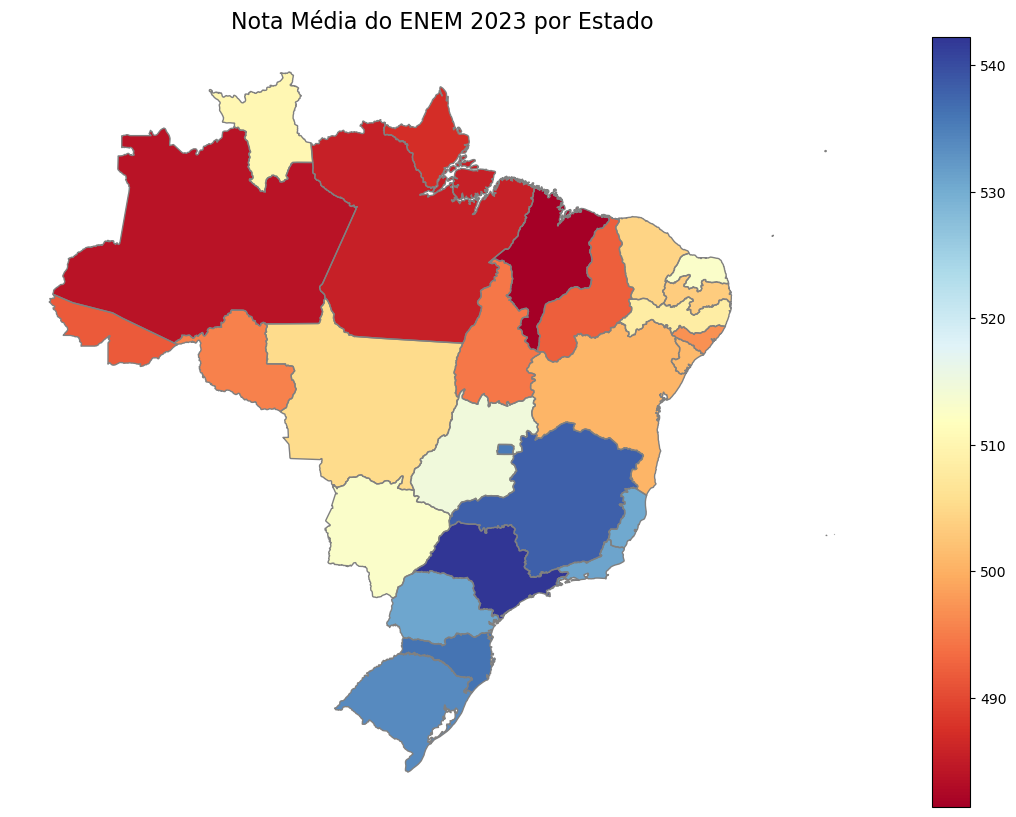

#### Versão Mapa Interativo via Folium

In [ ]:
# Criar o mapa base centralizado no Brasil
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4, tiles='CartoDB positron')

# Adicionar o choropleth ao mapa
Choropleth(
    geo_data=mapa_brasil,  # Dados geográficos
    data=mapa_brasil,      # Dados com valores a serem plotados
    columns=['SG_UF_PROVA', 'NOTA_MEDIA'],  # Colunas: identificação e valor
    key_on='feature.properties.SG_UF_PROVA',  # Chave para unir os dados
    fill_color='YlGnBu',  # Paleta de cores
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Nota Média do ENEM 2023'
).add_to(m)

# Exibir o mapa
m.save("mapa_interativo.html")

O mapa apresenta uma análise das notas médias obtidas pelos estudantes no ENEM de 2023, distribuídas por estado brasileiro. Utilizando uma escala de cores que varia entre vermelho e azul, o gráfico evidencia as diferenças no desempenho médio entre as unidades federativas. A interpretação segue a seguinte lógica:

Tons de vermelho representam os estados com as menores médias de desempenho.
Tons intermediários (amarelo e laranja) indicam desempenhos médios próximos à mediana nacional.
Tons de azul destacam os estados com as maiores médias no exame.

A análise revela desigualdades regionais no desempenho dos estudantes brasileiros, uma tendência historicamente associada a fatores como diferenças na qualidade do ensino, desigualdade de infraestrutura educacional e indicadores socioeconômicos. Estados das regiões Norte e Nordeste aparecem majoritariamente em tons de vermelho e laranja, sugerindo médias mais baixas, enquanto estados das regiões Sul e Sudeste predominam em tons de azul, indicando melhores resultados.

Essa disparidade reflete desafios estruturais na educação brasileira, incluindo o acesso desigual a recursos, formação de professores e apoio ao estudante. Estados do Centro-Oeste, por sua vez, apresentam resultados intermediários, com desempenhos que oscilam entre as médias mais altas e mais baixas.

Essa análise pode ser utilizada para identificar áreas prioritárias para investimentos em políticas públicas voltadas à educação, com o objetivo de reduzir as desigualdades regionais e melhorar os resultados dos estudantes em todo o país.

## Renda e Desempenho

In [ ]:
# Excluindo as variáveis numero de inscricao e ano da prova

df2.drop(["NU_INSCRICAO", "NU_ANO"], axis = 1, inplace = True)

df2 = df2.dropna()

df2.rename({"NU_NOTA_CN": "Ciências da Natureza",
            "NU_NOTA_CH": "Ciências Humanas",
            "NU_NOTA_LC": "Linguagens",
            "NU_NOTA_MT": "Matemática",
            "NU_NOTA_REDACAO": "Redação"}, inplace = True, axis = 1)

# Converter a coluna q006 para categórico ordenado

notas = ["Ciências da Natureza", "Ciências Humanas","Linguagens", "Matemática","Redação"]

df2["Q006"] = pd.Categorical(df2["Q006"],ordered= True)

notas_por_renda = df2.groupby("Q006")[notas].mean()

round(notas_por_renda,2)

###  *Q006 - Renda mensal*
Com base nos dados do Enem 2023, disponíveis no site do Ministério da Educação, foi feita uma análise para verificar a relação entre a renda mensal familiar dos candidatos e o desempenho deles no exame. As informações sobre a renda foram obtidas no questionário socioeconômico, na questão 6 (Q006). De acordo com as respostas dos participantes, eles foram divididos em 17 categorias - de A a Q -, em que a categoria A corresponde à menor faixa de renda e Q à maior.



In [ ]:
## Frequencia das classes


frequencia = df2["Q006"].value_counts()

percentual = (frequencia/ frequencia.sum()) * 100

percentual = percentual.sort_values(ascending = False)



plt.figure(figsize= (16,10))

bars = plt.barh(percentual.index, percentual.values, color = "skyblue")

for bar, value in zip(bars, percentual.values):
    plt.text(
        bar.get_width() + 0.5,  # Posição no eixo X
        bar.get_y() + bar.get_height() / 2,  # Centraliza no eixo Y
        f"{value:.1f}%",  # Formato do valor percentual
        va="center"  # Alinha verticalmente
    )
plt.xlabel("Frequência")
plt.ylabel("Categorias")
plt.title("Distribuição Percentual - Q006")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

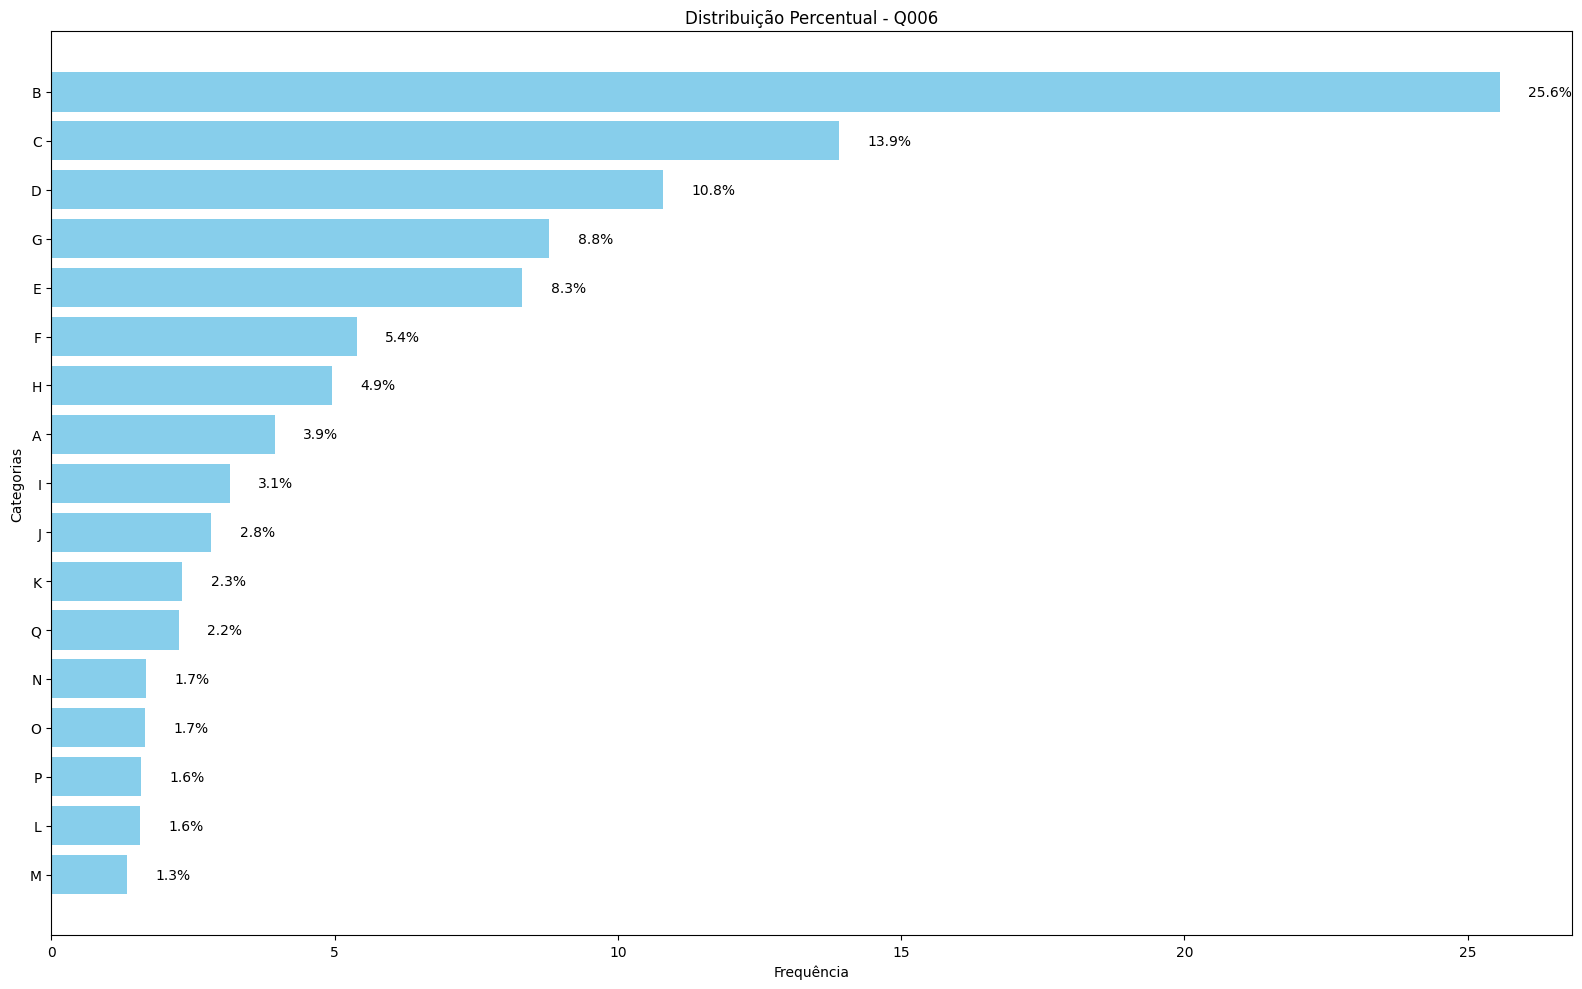

Do gráfico de barras horizontais, observa-se que a maior parte dos candidados - 67,4 % - pertencem às categorias B, C, D, G e E. Nelas a renda mensal está no intervalo de R$ 1 a R$ 5280 . As famílias que ganham mais de R$ 10.560 (de L a Q) possuem distribuições semelhantes.
As classes são dadas por:
- A: Nenhuma Renda  

- B: Até R$ 1320

- C: De R$ 1320 até R$ 1980

- D: De R$ 1980,01 até R$ 2640

- E: De R$ 2640,01 até R$ 3300

- F: De R$ 3300,01 até R$ 3960

- G: De R$ 3960,01 até R$ 5280

- H: De R$ 5280,01 até R$ 6600

- I: De R$ 6600,01 até R$ 7290

- J: De R$ 7290,01 até R$ 9240

- K: De R$ 9240,01 até R$ 10560

- L: De R$ 10560,01 até R$ 11800

- M: De R$ 11880,01 até R$ 13200

- N: De R$ 13200,01 até R$ 15840

- O: De R$ 15840,01 até R$ 19800

- P: De R$ 19800,01 até R$ 26400

- Q: Acima de R$ 26400

In [ ]:
notas_enem = {"Linguagens": [287,516.2,820.8],
              "Ciências Humanas": [289.9,522,823],
              "Ciências da Natureza": [314.4,497.4,868.6],
              "Matemática": [319.8,534.9, 958.6],
              "Redação": [40, 641.6, 1000]}

df_enem = pd.DataFrame(
    notas_enem, 
    index=["Mínimo", "Média", "Máximo"]  # Define os rótulos das linhas
)

# Criando a tabela
fig, ax = plt.subplots(figsize=(10, 4))  # Aumenta o tamanho para acomodar texto
ax.axis("off")  # Remove os eixos
tabela = ax.table(
    cellText=df_enem.values,  # Valores da tabela
    rowLabels=df_enem.index,  # Rótulos das linhas
    colLabels=df_enem.columns,  # Rótulos das colunas
    cellLoc="center",  # Centraliza o texto
    loc="center",  # Coloca a tabela no centro
)

# Ajustando tamanho das células
tabela.auto_set_font_size(False)  # Permite ajuste manual do tamanho da fonte
tabela.set_fontsize(10)  # Define tamanho da fonte
tabela.scale(1.5, 1.5)  # Ajusta o tamanho da tabela

# Salva como imagem e exibe
plt.show()

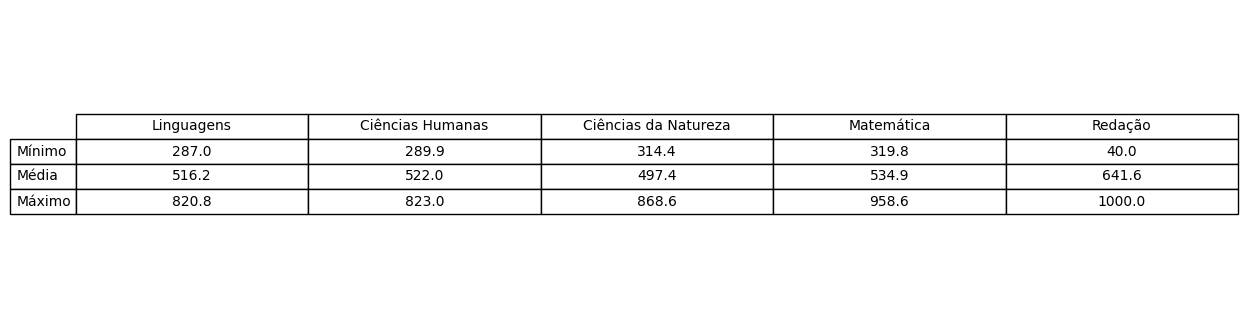

De acordo com os dados do Inep, as notas mínimas, médias e máximas em cada área foram:
- Linguagens: 287; 516,2 e 820,8
- Ciências Humanas: 289,9; 522 e 823
- Ciências da Natureza: 314,4; 497,4 e 868,6 
- Matemática: 319,8; 534,9 e 958,6
- Redação: 40; 641,6 e 1000

In [ ]:
notas_long = notas_por_renda.reset_index().melt(id_vars="Q006", 
                                                var_name="Tipo de Nota", 
                                                value_name="Média")

plt.figure(figsize=(14, 8))  
sns.barplot(data=notas_long, x="Q006", y="Média", hue="Tipo de Nota", palette="muted")

plt.title("Média das Notas por Faixa de Renda e Tipo de Nota", fontsize=16)
plt.xlabel("Faixa de Renda (Q006)", fontsize=12)
plt.ylabel("Média das Notas", fontsize=12)
plt.xticks(rotation=45) 
plt.legend(title="Tipo de Nota", fontsize=10, title_fontsize=12)
plt.tight_layout()

plt.show()

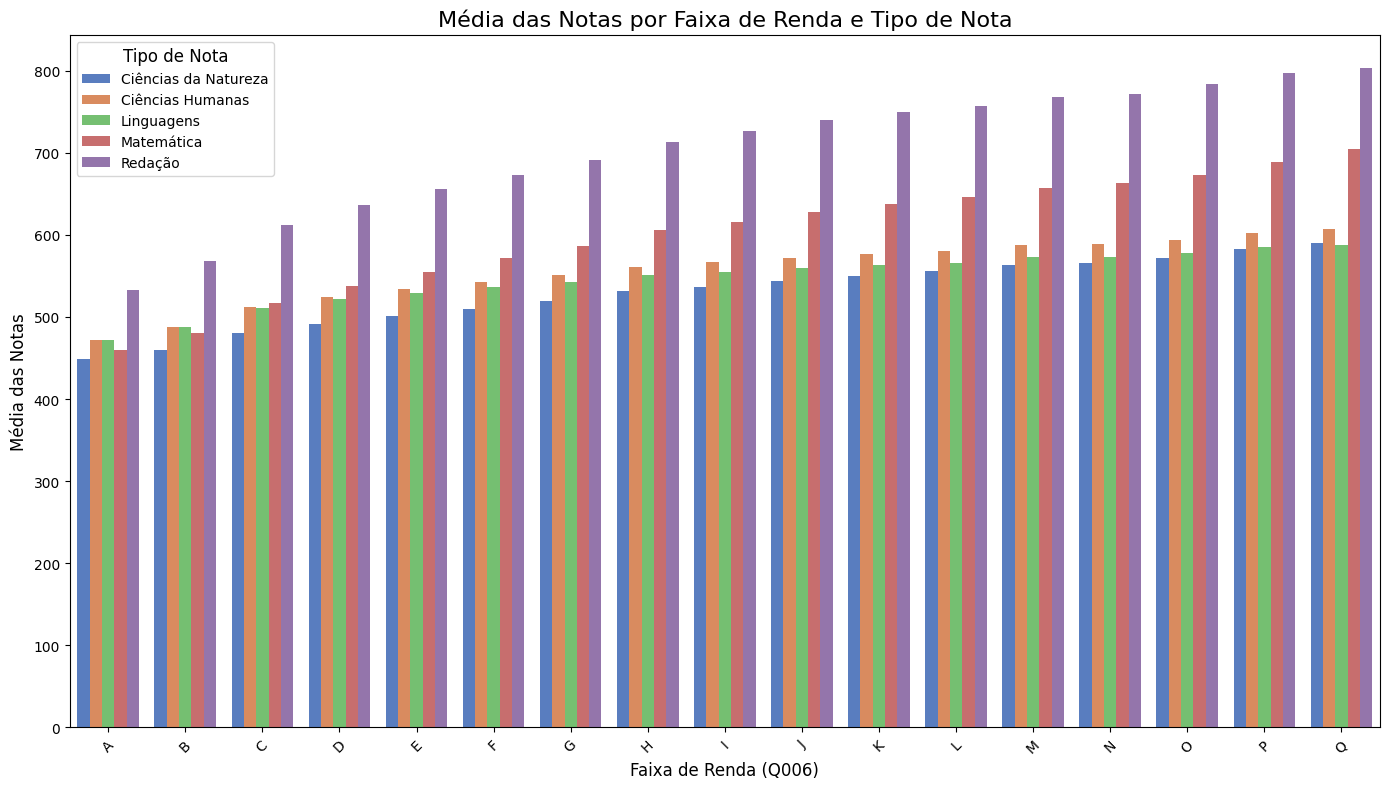

Do gráfico e da tabela, observa-se que os alunos das categorias A,B,C e D possuem a nota menor do que a média em todas as áreas. Essa padrão é alterado a partir da E. Conforme a maior renda mensal, é perceptivel o aumento das notas médias - sobretudo-  em matemática e redação.

## Redação e Presença de Participantes

In [ ]:
cols = ['NU_NOTA_REDACAO', 'TP_ESCOLA']

enem_data_filter = enem_data_filter[enem_data_filter['TP_ESCOLA'].isin([2, 3])]
enem_data_filter['TP_ESCOLA'] = enem_data_filter['TP_ESCOLA'].replace({2: 'Pública', 3: 'Privada'})

#### Nota na Redação por Tipo de Escola

In [ ]:
boxplotRed = px.box(
    enem_data_filter, 
    x='TP_ESCOLA', 
    y='NU_NOTA_REDACAO', 
    title="Nota na redação por tipo de escola", 
    labels={'TP_ESCOLA': 'Tipo de Escola', 'NU_NOTA_REDACAO': 'Nota na Redação'},
    color='TP_ESCOLA',
    color_discrete_sequence=["#8c8648", "#d1c545"],
    width=600,
    height=600
)

boxplotRed.show()

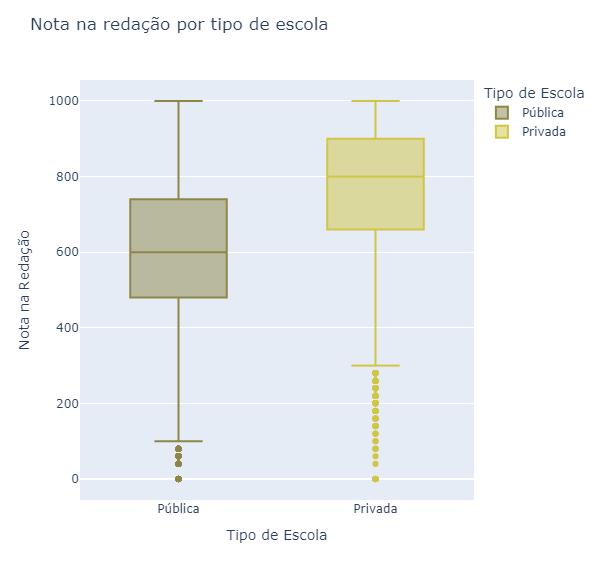

#### Presença na prova analisada por Autodeclaração Racial dos participantes

In [ ]:
cols = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_COR_RACA']
data_presenca = dataset[cols]
data_presenca = data_presenca.dropna()

data_presenca = data_presenca[(data_presenca['TP_COR_RACA'] != 0) & (data_presenca['TP_COR_RACA'] != 6)]
data_presenca['TP_COR_RACA'] = data_presenca['TP_COR_RACA'].replace({1: 'Branca', 2: 'Preta', 3: 'Parda', 4: 'Amarela', 5: 'Indígena'})

data_presenca['AUSENTE'] = (data_presenca['TP_PRESENCA_CN'] == 0) & (data_presenca['TP_PRESENCA_CH'] == 0) & (data_presenca['TP_PRESENCA_LC'] == 0) & (data_presenca['TP_PRESENCA_MT'] == 0)


In [ ]:
inscrito_counts = data_presenca['TP_COR_RACA'].value_counts()
ausente_counts = data_presenca[data_presenca['AUSENTE'] == True]['TP_COR_RACA'].value_counts()

presencaRaca = pd.DataFrame({'Inscritos': inscrito_counts, 'Ausentes': ausente_counts}).reset_index()
presencaRaca = presencaRaca.rename(columns={'index': 'TP_COR_RACA'})

presencaRaca_melt = pd.melt(presencaRaca, id_vars='TP_COR_RACA')
presencaRaca_melt.columns = ['TP_COR_RACA', 'Inscritos', 'Quantidade']

plt.figure(figsize=(12, 6))
sns.barplot(x='TP_COR_RACA', y='Quantidade', hue='Inscritos', data=presencaRaca_melt, palette=sns.color_palette("Set2", 2))
plt.title('Presença na prova por cor/raça')
plt.xlabel('Cor/raça')
plt.ylabel('Contagem (milhões)')
plt.show()

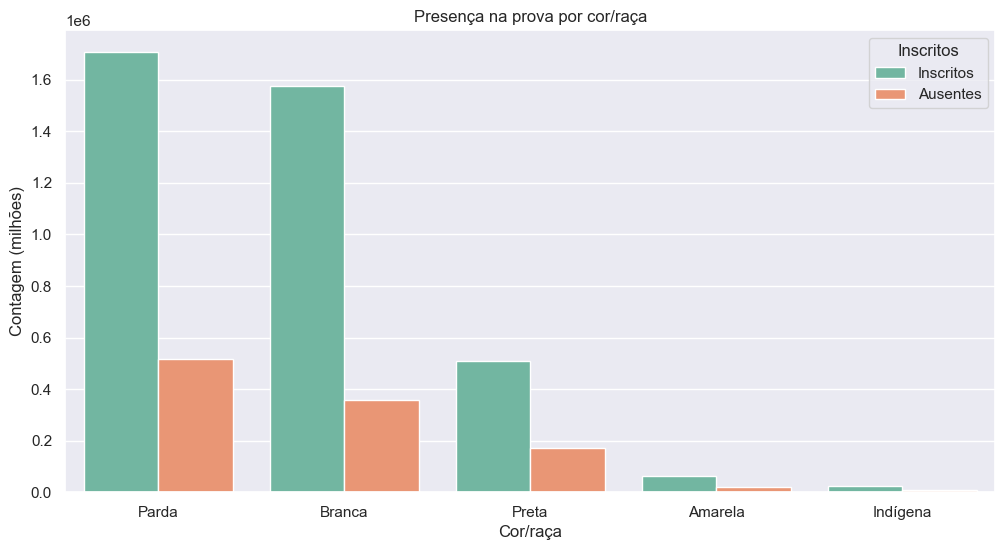

Podemos notar que, em termos proporcionais, pessoas de cor/raça preta foram os mais faltantes.

## Análise de Regressão

#### _Tratamento dos Dados_

In [ ]:
# Tratamento da variável 'TP_SEXO' - Converte os valores de sexo para 0 (Masculino) e 1 (Feminino)
dataset['TP_SEXO'] = dataset['TP_SEXO'].map({'M': 0, 'F': 1})

# Tratamento da variável 'TP_COR_RACA' - Mapeia os valores de cor/raça para suas respectivas descrições
dataset['TP_COR_RACA'] = dataset['TP_COR_RACA'].map({0: 'Não declarado', 1: 'Branca', 2: 'Preta', 3: 'Parda', 4: 'Amarela', 5: 'Indígena'})

# Tratamento da variável 'TP_ESCOLA' - Mapeia os tipos de escola (Pública, Privada e Não Respondeu)
dataset['TP_ESCOLA'] = dataset['TP_ESCOLA'].map({1: 'Não Respondeu', 2: 'Pública', 3: 'Privada'})

# Tratamento da variável 'TP_DEPENDENCIA_ADM_ESC' - Mapeia os tipos de dependência administrativa da escola (Federal, Estadual, Municipal, Privada)
dataset['TP_DEPENDENCIA_ADM_ESC'] = dataset['TP_DEPENDENCIA_ADM_ESC'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})

# Tratamento da variável 'TP_LOCALIZACAO_ESC' - Converte os valores de localização da escola (1 para urbano e 0 para rural)
dataset['TP_LOCALIZACAO_ESC'] = dataset['TP_LOCALIZACAO_ESC'].map({1: 1, 2: 0})

# Criação de uma nova coluna 'Nota média' - Calcula a média das notas das cinco áreas (Ciências da Natureza, Ciências Humanas, Linguagens, Matemática e Redação)
dataset['Nota média'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].mean(axis=1)

# Renomeação das colunas para nomes mais amigáveis e compreensíveis
dataset.columns = ['Sexo', 'Cor/Raça', 'Tipo de escola', 'Dependência administrativa da escola', 'Localização da escola_urbano', 
                   'Nota de Ciências da Natureza', 'Nota de Ciências Humanas', 'Nota de Linguagens e Códigos', 
                   'Nota de Matemática', 'Nota de Redação', 'Renda familiar', 'Nota média']

# Exibe as primeiras 5 linhas do dataframe após os tratamentos
dataset.head()


,Sexo,Cor/Raça,Tipo de escola,Dependência administrativa da escola,Localização da escola_urbano,Nota de Ciências da Natureza,Nota de Ciências Humanas,Nota de Linguagens e Códigos,Nota de Matemática,Nota de Redação,Renda familiar,Nota média
0,1,Parda,Pública,Estadual,1,459.0,508.5,507.2,466.7,880.0,C,564.28
1,1,Parda,Pública,Estadual,1,402.5,379.2,446.9,338.3,560.0,B,425.38
2,0,Parda,Pública,Estadual,1,608.2,667.6,607.9,691.9,780.0,D,671.12
3,1,Branca,Pública,Estadual,1,515.7,553.1,544.4,437.0,880.0,B,586.04
4,0,Branca,Pública,Estadual,1,523.8,576.3,596.5,628.1,600.0,D,584.94


In [ ]:
# Transforma as variáveis categóricas em colunas a serem ignoradas (dummies)
df = pd.get_dummies(dataset, columns=['Cor/Raça', 'Tipo de escola', 'Dependência administrativa da escola', 'Renda familiar'])
df.head()

A seguir, iremos remover as colunas "Cor/Raça_Branca", "Tipo de escola_Privada", "Tipo de escola_ Não Respondeu", "Dependência administrativa da escola_Privada" e "Renda familiar_A" do conjunto de dados. Com isso, a comparação dos coeficientes da regressão será realizada da seguinte maneira:

- Cor/Raça será comparado em relação a pessoas brancas.

- Tipo de escola será comparado em relação às escolas privadas.

- Dependência administrativa da escola será comparado com a dependência privada.

- Renda familiar será comparado com a categoria "não ter renda".

In [ ]:
## Trata os valores booleanos como 0 e 1 e remove as colunas que não serão utilizadas
df = df.drop(columns=['Cor/Raça_Não declarado', 'Cor/Raça_Branca', 'Tipo de escola_Não Respondeu', 'Tipo de escola_Privada', 'Dependência administrativa da escola_Privada',
                 'Renda familiar_A'])
df.replace(False, 0, inplace=True)
df.replace(True, 1, inplace=True)
df.head()

# Renomeia as colunas
df.columns = ['Mulher', 'Escola Urbana', 'Nota de Ciências da Natureza', 'Nota de Ciências Humanas', 'Nota de Linguagens e Códigos', 'Nota de Matemática', 'Nota de Redação', 'Nota média', 'Amarela', 'Indígena', 'Parda', 'Preta', 'Escola Pública', 'Escola Estadual', 'Escola Federal', 'Escola Municipal', 'Renda familiar B', 'Renda familiar C', 'Renda familiar D', 'Renda familiar E', 'Renda familiar F', 'Renda familiar G', 'Renda familiar H', 'Renda familiar I', 'Renda familiar J', 'Renda familiar K', 'Renda familiar L', 'Renda familiar M', 'Renda familiar N', 'Renda familiar O', 'Renda familiar P', 'Renda familiar Q']

C:\Users\felip\AppData\Local\Temp\ipykernel_432\2399587185.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(True, 1, inplace=True)


In [9]:
# Faz uma regressão linear na nota média usando statsmodels
X = df.drop(columns=['Nota média', 'Nota de Ciências da Natureza', 'Nota de Ciências Humanas', 'Nota de Linguagens e Códigos', 'Nota de Matemática', 'Nota de Redação'])
X = sm.add_constant(X)
y = df['Nota média']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Nota média   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                 1.363e+04
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:33:25   Log-Likelihood:            -4.1923e+06
No. Observations:              721429   AIC:                         8.385e+06
Df Residuals:                  721402   BIC:                         8.385e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              528.3155      0.762  

In [10]:
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML

stargazer = Stargazer([model])

display(HTML(stargazer.render_html()))


C:\Users\felip\AppData\Local\Temp\ipykernel_432\3489366349.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=model.params[1:], y=model.params[1:].index, palette=['darkgoldenrod'])
C:\Users\felip\AppData\Local\Temp\ipykernel_432\3489366349.py:5: UserWarning: 
The palette list has fewer values (1) than needed (26) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model.params[1:], y=model.params[1:].index, palette=['darkgoldenrod'])


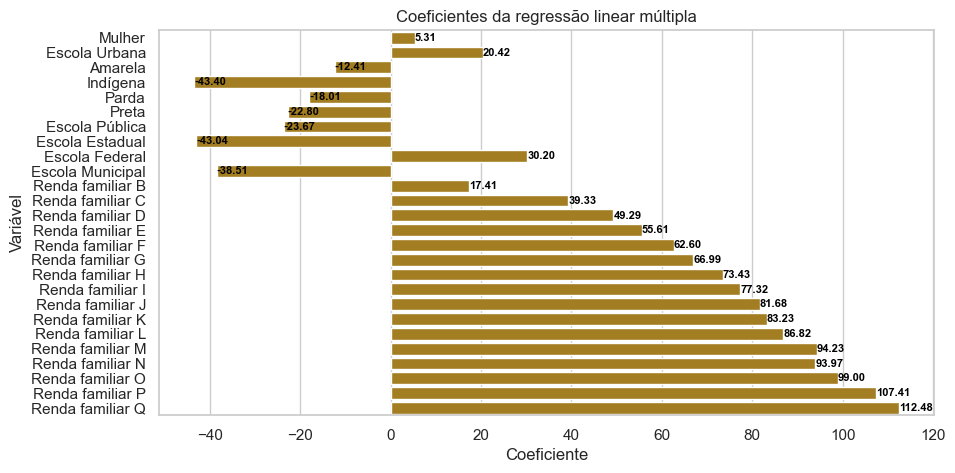

In [ ]:

# Setando o gráfico da regressão linear múltipla
sns.set(style='whitegrid')
plt.rc('font', family='Arial', size=12)
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=model.params[1:], y=model.params[1:].index, palette=['darkgoldenrod'])

# Adiciona os valores dos coeficientes nas barras
for i, v in enumerate(model.params[1:]):
    ax.text(v, i, f'{v:.2f}', color='black', va='center', fontweight='bold', fontsize=8)

plt.xlabel('Coeficiente')
plt.ylabel('Variável')
plt.title('Coeficientes da regressão linear múltipla')
plt.gca().set_facecolor('white')
plt.show()

# Explicação do gráfico:

O gráfico mostra os coeficientes de uma Regressão Linear Múltipla das variáveis selecionadas sobre a nota média do enem 2023.

## Mulher: 
Mulheres, têm em média, 5.31 pontos na nota média a mais em relação a homens.
## Escola Urbana: 
Escolas em zonas urbanas tem em média 20.42 pontos a mais em relação a escolas localizadas em zonas rurais
## Autoidentificação racial: 
Pessoas que se autoidentificam como Amarela, Indígena, Parda ou Preta tem em médias notas menores que pessoas autoidentificadas como brancas (destaque para indígenas com coeficiente bem expressivo negativamente)
## Escola Pública: 
Estudantes de escola pública tem em média 43.04 pontos a menos que estudantes de escola particular
## Administração da escola: 
Escolas estaduais e municipais tem um desempenho médio inferior a escolas privadas. Porém, estudantes de escolas federais tem nota média maior em relação a estudantes de escolas privadas.
## Renda familiar: 
O IBGE classifica a renda familiar nos microdados do enem com letras indo de "A" até "Q". "A" representa o estudante sem renda (menor nível de renda), "B" o segundo menor nível de renda, "C" o terceiro menor e assim por diante até "Q" que é o maior nível. Pela "escada" formada pelos coeficientes vemos que conforme a renda familiar aumenta a nota média expressivamente em relação ao estudante sem renda.